In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets,transforms
from torchvision.utils import make_grid
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score,classification_report
import numpy as np
%matplotlib inline

* The CIFAR-10 dataset consists of 60000 **32x32 colour images** in **10 classes**, with 6000 images per class. There are **50000 training** images and **10000 test** images.



In [2]:
class_names = ['plane', 'car', 'bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [3]:
def lossPlotting(train_losses,test_losses):
    train_losses_numpy = [loss.detach().numpy() for loss in train_losses]
    test_losses_numpy = [loss.detach().numpy() for loss in test_losses]

    # Now, you can plot the NumPy arrays
    plt.plot(train_losses_numpy, label='training loss')
    plt.plot(test_losses_numpy, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.legend()
    plt.show()

def evaluate_model_on_all_test_set(model):
    # Create a loader for the entire the test set
    test_load_all = DataLoader(testData, batch_size=10000, shuffle=False)

    with torch.no_grad():
        correct = 0
        for X_test, y_test in test_load_all:
            y_val = model(X_test)
            predicted = torch.max(y_val,1)[1]
            correct += (predicted == y_test).sum()
            
    return y_test,predicted

def confusion_metrix (y_test,predicted,class_names) :
    arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
    df_cm = pd.DataFrame(arr, class_names, class_names)
    plt.figure(figsize = (9,6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")
    plt.show();
    
def Acc(y_test,predicted):
    accuracy= []
    
    dicPred = {i:[] for i in range(0,10)}
    actual = [1]*1000
    
    for i,j in zip(y_test.view(-1),predicted.view(-1)):
        i = i.item()
        if i == j :
            dicPred[i].append(1)
        else:
            dicPred[i].append(0)
        
    for i in range(0,10):
        accuracy.append(accuracy_score(actual,dicPred[i]))
    
    return accuracy

def plotting (score,class_names,title):
    sns.barplot(x=class_names ,y=score)
    plt.title(title)
    plt.show()


## Data Preprocessing

* In this section i did some transformations 
* First , I doubled checked that image size is 32
* Afterthat , I augmented data by making RandomHorizontalFlip and RandomRotation
* Finally , I normalized data by these mean and std as i many researchers used it as i make a faster converge

In [4]:
imgSize = 32 
mean , std = [0.485, 0.456, 0.406] , [0.229, 0.224, 0.225]  # I used these mean and std as i see many researchers used it as i make a faster converge

# Making transformation on data which are resizing , RandomHFlip , RandomRotation and Normalization
transformTrain = transforms.Compose([
    transforms.Resize((imgSize,imgSize)),
    transforms.RandomHorizontalFlip(), # default is .5
    transforms.RandomRotation(20) ,
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])


transformTest = transforms.Compose([
    transforms.Resize((imgSize,imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])


trainData = datasets.CIFAR10(root='./Cifar',train=True,download=True,transform=transformTrain)
testData = datasets.CIFAR10(root='./Cifar',train=False,download=True,transform=transformTest)




100%|██████████| 170498071/170498071 [00:03<00:00, 43107676.20it/s]


Extracting ./Cifar/cifar-10-python.tar.gz to ./Cifar
Files already downloaded and verified


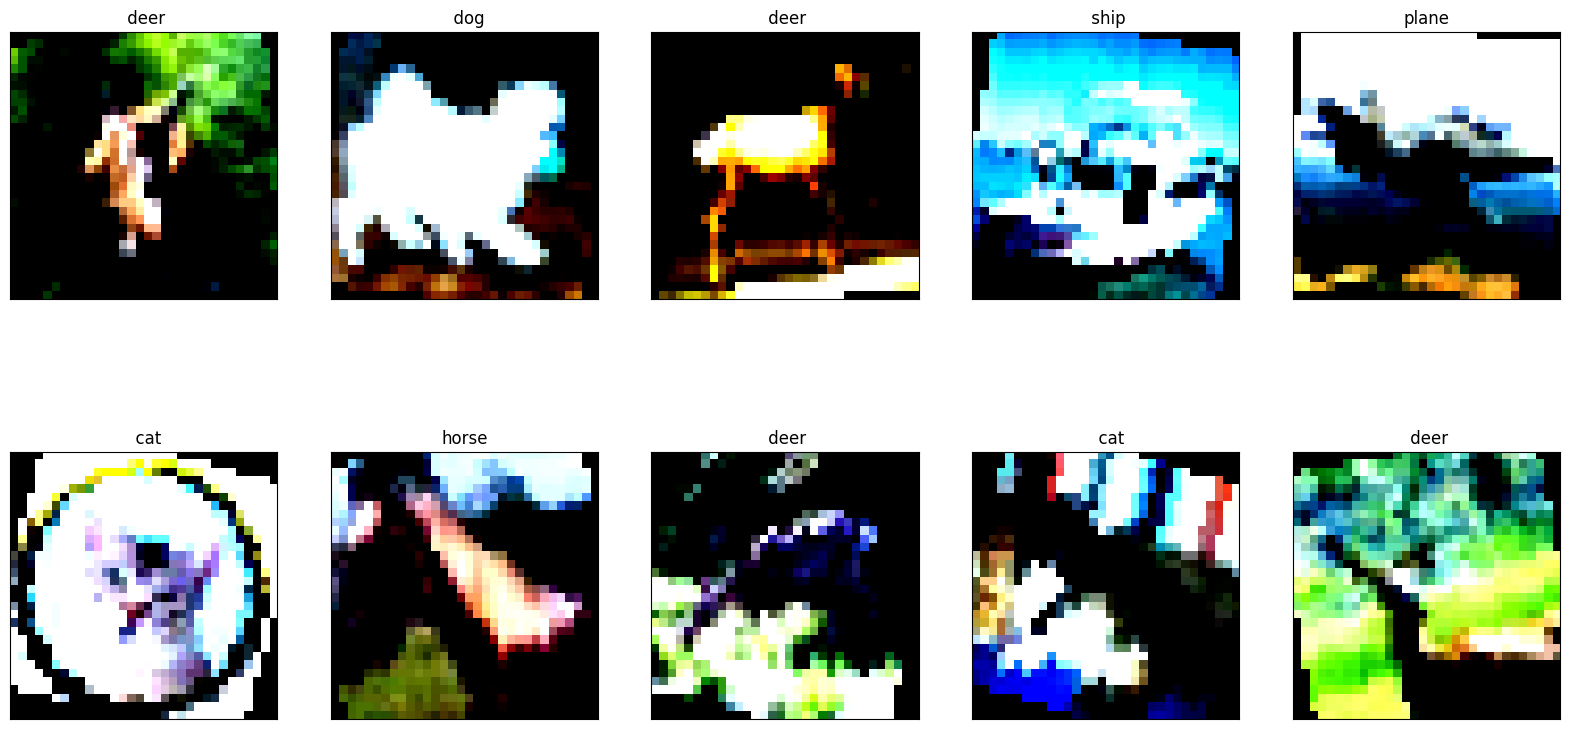

In [5]:
# Let's convert tensor image to numpy using im_convert function for imshow to print the img
def im_convert (im):
    return np.transpose(im.numpy(),(1,2,0))

fig = plt.figure(figsize=(20, 10)) 

for idx,j in zip (np.arange(10),np.random.randint(0,50000,10)):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    
    # Note: imshow cant print tensor !
    plt.imshow(im_convert(trainData[j][0]))
    ax.set_title(class_names[trainData[j][1]])


In [6]:
# Let's put train , validation data into batches 
trainLoader = torch.utils.data.DataLoader(dataset=trainData, batch_size=100)
testLoader = torch.utils.data.DataLoader(dataset=testData, batch_size=100)


## Model Building

**First trial**
* I created a model with 2 convolutions layers 
    * The first layer has 6 filters with kernel Size (3,3)
    * The second layer has 16 filters with kernel Size (4,4)
* After convlution layers , I made 3 fully connected layers
    

In [11]:
class Model(nn.Module):
    
    def __init__(self,outCo1=6,outCo2=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=outCo1,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=outCo2,kernel_size=4,stride=1)
        self.fc1 = nn.Linear(16*5*5,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)
        
    
    def forward(self,x):
        x = f.relu(self.conv1(x))
        x = f.max_pool2d(x,3,2)
        x = f.relu(self.conv2(x))
        x = f.max_pool2d(x,3,2)
        x = x.view(-1, 5*5*16)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        
        return f.log_softmax(x,dim=1)

In [12]:
model = Model()
modeCriterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
model

Model(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Model Training and Evaluation

In [14]:
def trainingFunc(model,trainLoader,testLoader,epochs = 10):
    start_time = time.time()

    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []

    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0

        # Run the training batches
        for b, (X_train, y_train) in enumerate(trainLoader):
            b+=1

            # Apply the model
            y_pred = model(X_train)
            loss = modeCriterion(y_pred, y_train)

            # Tally the number of correct predictions
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            # Update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Print interim results
            if b%500 == 0:
                print(f'epoch: {i:2} loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(100*b):7.3f}%')

        train_losses.append(loss)
        train_correct.append(trn_corr)

        # Run the testing batches
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(testLoader):

                # Apply the model
                y_val = model(X_test)

                # Tally the number of correct predictions
                predicted = torch.max(y_val.data, 1)[1] 
                tst_corr += (predicted == y_test).sum()

        loss = modeCriterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)
         
    print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed 
    
    return train_losses,test_losses,train_correct,test_correct

In [15]:
train_losses,test_losses,train_correct,test_correct = trainingFunc(model,trainLoader,testLoader,epochs = 25)

epoch:  0 loss: 1.45120800 accuracy:  38.078%
epoch:  1 loss: 1.40659642 accuracy:  47.992%
epoch:  2 loss: 1.29072535 accuracy:  51.914%
epoch:  3 loss: 1.29352987 accuracy:  54.388%
epoch:  4 loss: 1.20883632 accuracy:  56.330%
epoch:  5 loss: 1.14065588 accuracy:  57.652%
epoch:  6 loss: 1.26011705 accuracy:  58.820%
epoch:  7 loss: 1.16807544 accuracy:  59.396%
epoch:  8 loss: 1.23490238 accuracy:  60.674%
epoch:  9 loss: 1.13523257 accuracy:  61.336%
epoch: 10 loss: 1.14158225 accuracy:  62.030%
epoch: 11 loss: 1.20345008 accuracy:  62.504%
epoch: 12 loss: 1.24205315 accuracy:  62.780%
epoch: 13 loss: 1.11832619 accuracy:  63.484%
epoch: 14 loss: 1.08603954 accuracy:  63.848%
epoch: 15 loss: 1.05501914 accuracy:  64.458%
epoch: 16 loss: 1.09542561 accuracy:  64.730%
epoch: 17 loss: 1.04121363 accuracy:  65.028%
epoch: 18 loss: 1.08881271 accuracy:  65.272%
epoch: 19 loss: 1.18426204 accuracy:  65.846%
epoch: 20 loss: 1.04025638 accuracy:  66.100%
epoch: 21 loss: 1.03605342 accurac

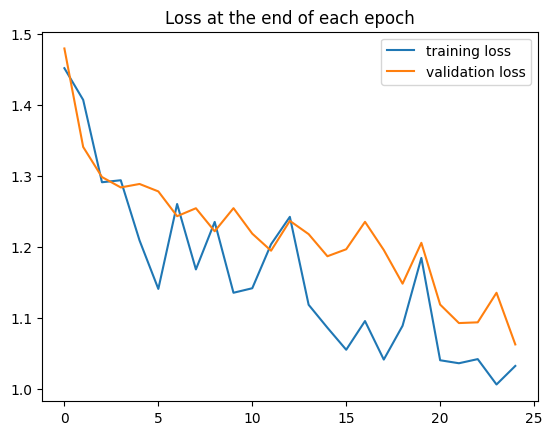

In [16]:
lossPlotting(train_losses,test_losses)

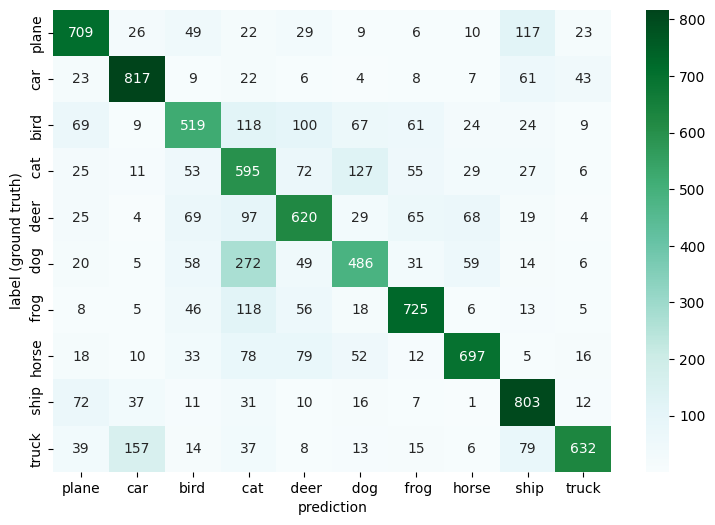

In [54]:
y_test,predicted = evaluate_model_on_all_test_set(model)
confusion_metrix (y_test,predicted,class_names)


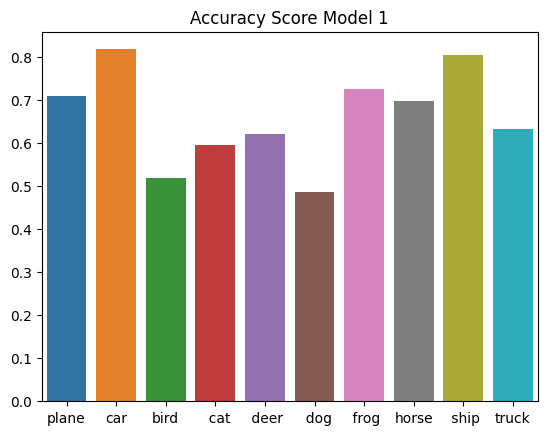

In [55]:
accuracy = Acc(y_test,predicted)
plotting (accuracy,class_names,'Accuracy Score Model 1')


In [56]:
print(classification_report(y_test,predicted,target_names=class_names))


              precision    recall  f1-score   support

       plane       0.70      0.71      0.71      1000
         car       0.76      0.82      0.79      1000
        bird       0.60      0.52      0.56      1000
         cat       0.43      0.59      0.50      1000
        deer       0.60      0.62      0.61      1000
         dog       0.59      0.49      0.53      1000
        frog       0.74      0.72      0.73      1000
       horse       0.77      0.70      0.73      1000
        ship       0.69      0.80      0.74      1000
       truck       0.84      0.63      0.72      1000

    accuracy                           0.66     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.67      0.66      0.66     10000



### Second Trial

* If we looked at the loss and accuracy previous trial 
    * If we trained our model with more epochs the acc will increase
    * Although after each epoch th acc increased but it increased slowly
        * we may play with learning rate of Adam optimizer
        * As momentum has less hyperparameters we may try it with lr .003
    * The accuracy of test is **65%** and on train **66%** so we can :
        * increased a number of filters of convolutions to get more details of the image which will increase the performance
        * use deeper convolution
        * increase the number of fully connected layer and if overfitting ocurred we will use dropout
     
        


In [20]:
class Model(nn.Module):
    
    def __init__(self,outCo1=16,outCo2=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=outCo1,kernel_size=5,stride=1) 
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=outCo2,kernel_size=5,stride=1) # ((32 - 5 + 1) - 3 / 2   +1) - 5 +1 -3 / 2 +1 =
        self.fc1 = nn.Linear(32*4*4,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)
        
    
    def forward(self,x):
        x = f.relu(self.conv1(x))
        x = f.max_pool2d(x,3,2)
        x = f.relu(self.conv2(x))
        x = f.max_pool2d(x,3,2)
        x = x.view(-1, 32*4*4)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        
        return f.log_softmax(x,dim=1)

In [21]:
model2 = Model()
modeCriterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [22]:
model2

Model(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [23]:
train_losses,test_losses,train_correct,test_correct = trainingFunc(model2,trainLoader,testLoader,epochs = 15)

epoch:  0 loss: 1.48389053 accuracy:  39.914%
epoch:  1 loss: 1.26139033 accuracy:  51.500%
epoch:  2 loss: 1.27984762 accuracy:  56.326%
epoch:  3 loss: 1.08430743 accuracy:  59.326%
epoch:  4 loss: 1.14930689 accuracy:  61.304%
epoch:  5 loss: 1.07341504 accuracy:  62.852%
epoch:  6 loss: 1.02006376 accuracy:  64.026%
epoch:  7 loss: 1.00612545 accuracy:  65.212%
epoch:  8 loss: 1.03610134 accuracy:  65.836%
epoch:  9 loss: 0.94105041 accuracy:  66.578%
epoch: 10 loss: 0.94130576 accuracy:  67.166%
epoch: 11 loss: 0.89468825 accuracy:  67.956%
epoch: 12 loss: 0.98318833 accuracy:  68.118%
epoch: 13 loss: 0.86180329 accuracy:  68.488%
epoch: 14 loss: 0.80747199 accuracy:  68.838%
Test accuracy: 70.150%

Duration: 549 seconds


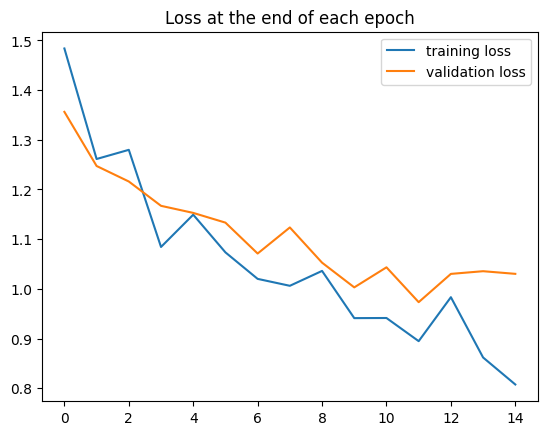

In [24]:
lossPlotting(train_losses,test_losses)

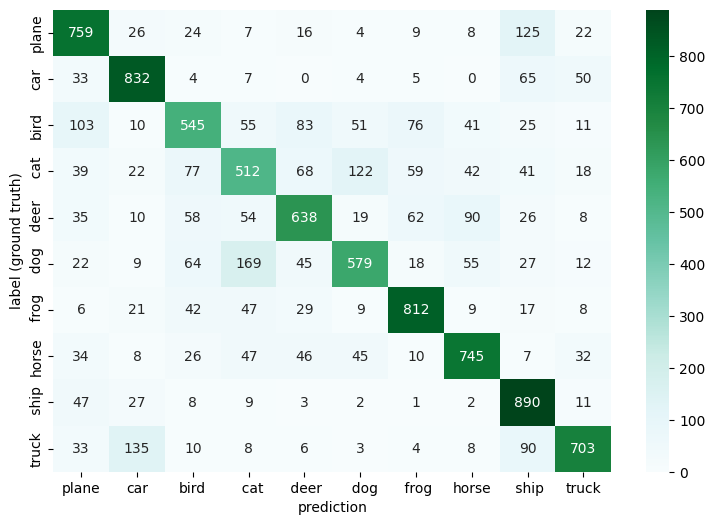

In [57]:
y_test,predicted = evaluate_model_on_all_test_set(model2)
confusion_metrix (y_test,predicted,class_names)


In [58]:
print(classification_report(y_test,predicted,target_names=class_names))


              precision    recall  f1-score   support

       plane       0.68      0.76      0.72      1000
         car       0.76      0.83      0.79      1000
        bird       0.64      0.55      0.59      1000
         cat       0.56      0.51      0.53      1000
        deer       0.68      0.64      0.66      1000
         dog       0.69      0.58      0.63      1000
        frog       0.77      0.81      0.79      1000
       horse       0.74      0.74      0.74      1000
        ship       0.68      0.89      0.77      1000
       truck       0.80      0.70      0.75      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



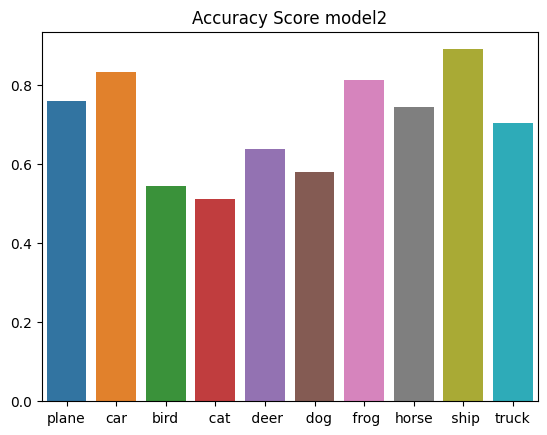

In [27]:
accuracy = Acc(y_test,predicted)
plotting (accuracy,class_names,'Accuracy Score model2')

* Our Test score is **70%** and train score **69%**
* In this trial we acheived our goal with **15 epochs** we got results better than the previous model 
* And If we increased number of epochs we will get more better score

### Third Trial

* As i read in **Hands on Machine Learning** book to prevent the problem of saturating or explosion which in fact we didn't have them use **He** weights 
    * So what if we tried to use **He** weights initiallization and use nore neurons in our hidden layers
    
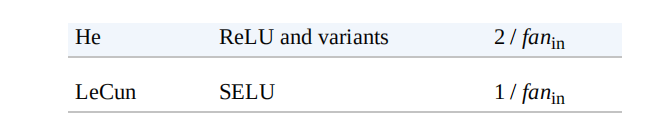

In [28]:
class Model(nn.Module):
    
    def __init__(self,outCo1=16,outCo2=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=outCo1,kernel_size=5,stride=1) 
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=outCo2,kernel_size=5,stride=1) # ((32 - 5 + 1) - 3 / 2   +1) - 5 +1 -3 / 2 +1 =
        self.fc1 = nn.Linear(32*4*4,512)
        torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.fc2 = nn.Linear(512,256)
        torch.nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.fc3 = nn.Linear(256,10)
        torch.nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        
    
    def forward(self,x):
        x = f.relu(self.conv1(x))
        x = f.max_pool2d(x,3,2)
        x = f.relu(self.conv2(x))
        x = f.max_pool2d(x,3,2)
        x = x.view(-1, 32*4*4)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        
        return f.log_softmax(x,dim=1)

In [29]:
model3 = Model()
modeCriterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

In [30]:
model3

Model(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [31]:
train_losses,test_losses,train_correct,test_correct = trainingFunc(model3,trainLoader,testLoader,epochs = 15)

epoch:  0 loss: 1.33160520 accuracy:  45.166%
epoch:  1 loss: 1.27414310 accuracy:  55.196%
epoch:  2 loss: 1.10213184 accuracy:  59.242%
epoch:  3 loss: 1.03201592 accuracy:  61.804%
epoch:  4 loss: 1.06691372 accuracy:  64.112%
epoch:  5 loss: 1.03272986 accuracy:  65.608%
epoch:  6 loss: 0.82594460 accuracy:  67.546%
epoch:  7 loss: 0.95517319 accuracy:  68.228%
epoch:  8 loss: 1.02040446 accuracy:  69.284%
epoch:  9 loss: 0.94770765 accuracy:  70.126%
epoch: 10 loss: 0.86268586 accuracy:  70.802%
epoch: 11 loss: 0.88895506 accuracy:  71.526%
epoch: 12 loss: 0.91749334 accuracy:  72.086%
epoch: 13 loss: 0.68346334 accuracy:  72.812%
epoch: 14 loss: 0.83054179 accuracy:  73.398%
Test accuracy: 70.710%

Duration: 573 seconds


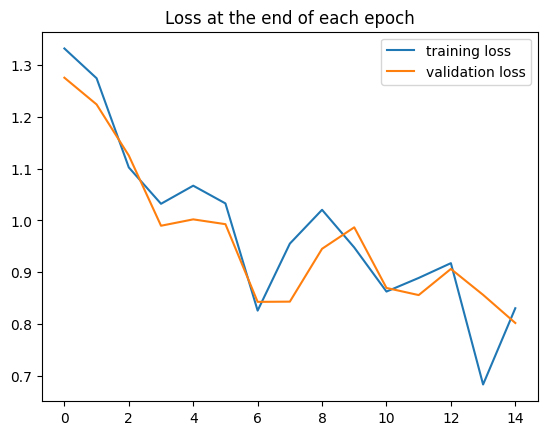

In [32]:
lossPlotting(train_losses,test_losses)

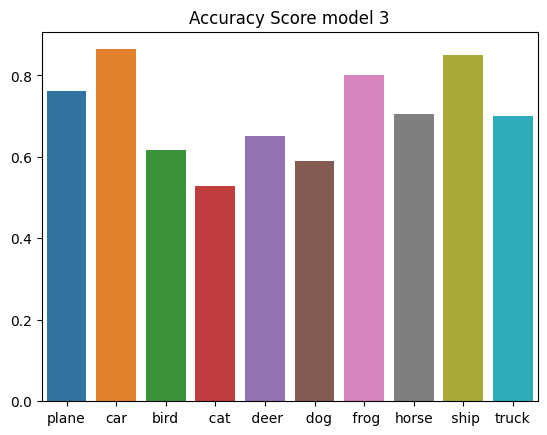

In [59]:
y_test,predicted = evaluate_model_on_all_test_set(model3)
accuracy = Acc(y_test,predicted)
plotting (accuracy,class_names,'Accuracy Score model 3')

In [60]:
print(classification_report(y_test,predicted,target_names=class_names))


              precision    recall  f1-score   support

       plane       0.74      0.76      0.75      1000
         car       0.74      0.86      0.80      1000
        bird       0.67      0.62      0.64      1000
         cat       0.50      0.53      0.51      1000
        deer       0.68      0.65      0.66      1000
         dog       0.63      0.59      0.61      1000
        frog       0.76      0.80      0.78      1000
       horse       0.80      0.71      0.75      1000
        ship       0.77      0.85      0.81      1000
       truck       0.80      0.70      0.75      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000

